In [1]:
import h5py, os
import numpy as np
import pandas as pd
from tqdm import tqdm
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt

from msfm.utils import files, observation, cross_statistics, power_spectra
from deep_lss.utils import configuration
from msi.utils import preprocessing, plotting

np.set_printoptions(precision=2)

# find sobol indices closest to Buzzard cosmology

In [2]:
meta_file = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/data/CosmoGridV1_metainfo.h5"
with h5py.File(meta_file, "r") as f:
    print(f.keys())
    print(f["parameters"].keys())

    grid_params = f["parameters/grid"][:]

<KeysViewHDF5 ['parameters', 'shell_info', 'simulations']>
<KeysViewHDF5 ['all', 'benchmark', 'fiducial', 'grid']>


In [3]:
buzzard_cosmo = np.array([0.286, 0.82, -1]) # h = 0.7, ns = 0.96, Omega_b = 0.046 
i_sobols = grid_params["sobol_index"]

cosmo_params = ["Om", "s8", "w0"]
grid_cosmo = np.stack([grid_params[param] for param in cosmo_params], axis=-1)

param_min = grid_cosmo.min(axis=0)
param_max = grid_cosmo.max(axis=0)
grid_cosmo_normalized = (grid_cosmo - param_min) / (param_max - param_min)

buzzard_cosmo_normalized = (buzzard_cosmo - param_min) / (param_max - param_min)

In [4]:
# distances = np.linalg.norm(grid_cosmo_normalized - buzzard_cosmo_normalized, axis=1)
distances = np.linalg.norm(grid_cosmo - buzzard_cosmo, axis=1)

n = 5
closest_indices = np.argsort(distances)[:n]
closest_sobols = i_sobols[closest_indices]
closest_points = grid_cosmo[closest_indices]

print("closest", n, "points:\n", closest_points)
print("distances", distances[closest_indices])
print("indices:", closest_indices)
print("i_sobols:", closest_sobols)

closest 5 points:
 [[ 0.28  0.83 -1.01]
 [ 0.3   0.83 -1.  ]
 [ 0.27  0.82 -0.97]
 [ 0.26  0.85 -1.  ]
 [ 0.28  0.82 -0.96]]
distances [0.02 0.02 0.04 0.04 0.04]
indices: [1954 2307 1483 2380 1585]
i_sobols: [114996 172798  40100 184644  57908]


In [5]:
print(grid_params["ns"][closest_indices])
print(grid_params["Ob"][closest_indices])
print(grid_params["H0"][closest_indices])

[0.99 0.99 0.97 0.98 0.95]
[0.04 0.05 0.05 0.04 0.05]
[65.9  65.27 68.59 68.43 73.13]


# load map-level Buzzard best fit

In [20]:
def get_MAP_constrained(chain, log_probs, fixed_cosmo_params, tolerance=1e-2, obs_label=""):
    n_cosmo_params = len(fixed_cosmo_params)
    mask = np.ones(len(chain), dtype=bool)
    for i in range(n_cosmo_params):
        mask &= (np.abs(chain[:, i] - fixed_cosmo_params[i]) < tolerance)
    
    if not np.any(mask):
        raise ValueError("No samples match the fixed parameters within tolerance")

    print(f"{np.sum(mask)} values within the tolerance for the fixed Om, s8, w0 for {obs_label}")
    
    filtered_chain = chain[mask]
    filtered_log_probs = log_probs[mask]
    best_idx = np.argmax(filtered_log_probs)
    
    return filtered_chain[best_idx][n_cosmo_params:]


# v14

### clustering

In [21]:
# classic-frost-1096 (https://wandb.ai/eth-cosmo/y3-deep-lss/runs/fp2vxm07/overview)
# first v14 clustering probes run
model_dir = "/pscratch/sd/a/athomsen/run_files/v14/extended/clustering/mutual_info/2025-05-14_23-10-45_deepsphere_default"
flow_dir = os.path.join(model_dir, "240000_steps_likelihood_sigmoid/likelihood_flow")

params = ["Om", "s8", "w0", "bg1", "bg2", "bg3", "bg4"]

In [28]:
obs = "Buzzard_mean"
log_probs = np.load(os.path.join(flow_dir, f"log_probs_{obs}.npy"))
chain = np.load(os.path.join(flow_dir, f"chain_{obs}.npy"))

tomo_bg_buzzard_mean = get_MAP_constrained(chain, log_probs, buzzard_cosmo, tolerance=1e-2)
# tomo_bg_buzzard_mean = get_MAP_constrained(chain, log_probs, buzzard_cosmo, tolerance=5e-1)
print(tomo_bg_buzzard_mean)
# [1.38 1.54 1.68 1.78]

300 values within the tolerance for the fixed Om, s8, w0 for 
[1.38 1.54 1.68 1.78]


In [31]:
buzzard_indices = list(range(0, 16))
buzzard_indices.remove(1)
tomo_bg_buzzard_single = []
for i in buzzard_indices:
    obs = f"Buzzard_{i}"
    flow_dir = os.path.join(model_dir, "240000_steps_likelihood_sigmoid/likelihood_flow")
    log_probs = np.load(os.path.join(flow_dir, f"log_probs_{obs}.npy"))
    chain = np.load(os.path.join(flow_dir, f"chain_{obs}.npy"))

    try:
        # MAP = get_MAP_constrained(chain, log_probs, buzzard_cosmo, tolerance=5e-2)
        MAP = get_MAP_constrained(chain, log_probs, buzzard_cosmo, tolerance=1e-2, obs_label=obs)
        tomo_bg_buzzard_single.append(MAP)
    except ValueError:
        print(f"No best fit parameters for {obs}")
    
tomo_bg_buzzard_flock = np.stack(tomo_bg_buzzard_single, axis=0)

No best fit parameters for Buzzard_0
No best fit parameters for Buzzard_2
539 values within the tolerance for the fixed Om, s8, w0 for Buzzard_3
533 values within the tolerance for the fixed Om, s8, w0 for Buzzard_4
160 values within the tolerance for the fixed Om, s8, w0 for Buzzard_5
354 values within the tolerance for the fixed Om, s8, w0 for Buzzard_6
332 values within the tolerance for the fixed Om, s8, w0 for Buzzard_7
3 values within the tolerance for the fixed Om, s8, w0 for Buzzard_8
96 values within the tolerance for the fixed Om, s8, w0 for Buzzard_9
363 values within the tolerance for the fixed Om, s8, w0 for Buzzard_10
92 values within the tolerance for the fixed Om, s8, w0 for Buzzard_11
73 values within the tolerance for the fixed Om, s8, w0 for Buzzard_12
30 values within the tolerance for the fixed Om, s8, w0 for Buzzard_13
263 values within the tolerance for the fixed Om, s8, w0 for Buzzard_14
39 values within the tolerance for the fixed Om, s8, w0 for Buzzard_15


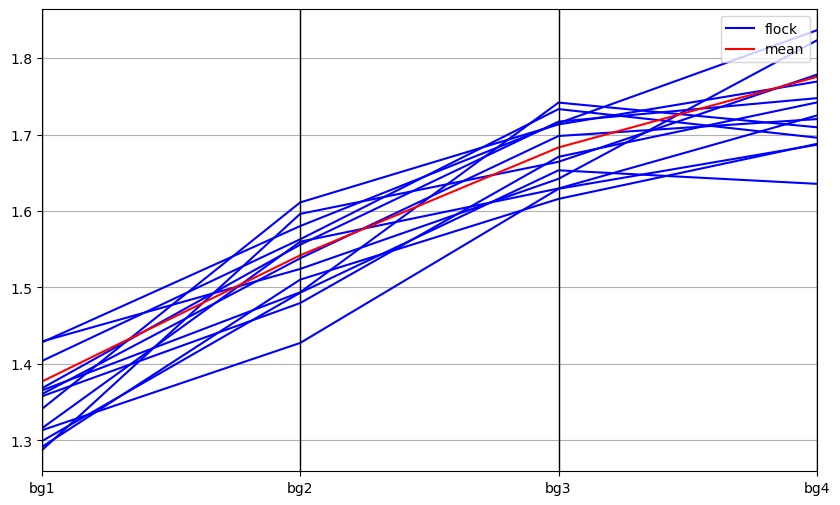

In [33]:
bgs = [f"bg{i}" for i in range(1,5)]
df = pd.DataFrame(tomo_bg_buzzard_flock, columns=bgs)
df['label'] = 'flock'
point_df = pd.DataFrame([tomo_bg_buzzard_mean], columns=bgs)
point_df['label'] = 'mean'
full_df = pd.concat([df, point_df], ignore_index=True)

plt.figure(figsize=(10, 6))
parallel_coordinates(full_df, 'label', color=['blue', 'red'])
plt.grid(True)
plt.show()

# load Buzzard $C_\ell$ best fit

In [ ]:
# def get_MAP(obs_label):
#     chain = np.load(os.path.join(cls_dir, f"chain_{obs_label}.npy"))
#     log_probs = np.load(os.path.join(cls_dir, f"log_probs_{obs_label}.npy"))
    
#     MAP_params = chain[np.argmax(log_probs)]
#     MAP_dict = {p: np.round(v, 3) for p, v in zip(params, MAP_params)}

#     return [MAP_dict[bg] for bg in bgs]

# def get_MAP_constrained(obs_label, fixed_cosmo_params, tolerance=1e-2):
#     chain = np.load(os.path.join(cls_dir, f"chain_{obs_label}.npy"))
#     log_probs = np.load(os.path.join(cls_dir, f"log_probs_{obs_label}.npy"))

#     n_cosmo_params = len(fixed_cosmo_params)
#     mask = np.ones(len(chain), dtype=bool)
#     for i in range(n_cosmo_params):
#         mask &= (np.abs(chain[:, i] - fixed_cosmo_params[i]) < tolerance)
    
#     if not np.any(mask):
#         raise ValueError("No samples match the fixed parameters within tolerance")

#     print(f"{np.sum(mask)} values within the tolerance for the fixed Om, s8, w0")
    
#     filtered_chain = chain[mask]
#     filtered_log_probs = log_probs[mask]
#     best_idx = np.argmax(filtered_log_probs)
    
#     return filtered_chain[best_idx][n_cosmo_params:]


In [ ]:
# cls_dir =  "/pscratch/sd/a/athomsen/run_files/v14/cls/lensing=False,clustering=True,standard=False,log=True,cosine=False,steps=400000/32mpc_sigmoid/likelihood_flow"
# params = ["Om", "s8", "w0", "bg1", "bg2", "bg3", "bg4"]
# bgs = [f"bg{i}" for i in range(1,5)]

# buzzard_indices = list(range(0, 16))
# buzzard_indices.remove(1)
# tomo_bg_single_buzzard = []
# for i in buzzard_indices:
#     # tomo_bg_single_buzzard.append(get_MAP(f"Buzzard_{i}"))
#     tomo_bg_single_buzzard.append(get_MAP_constrained(f"Buzzard_{i}", buzzard_cosmo))

# tomo_bg_buzzard_flock = np.stack(tomo_bg_single_buzzard, axis=0)
# print(tomo_bg_buzzard_flock)

In [ ]:
# # tomo_bg_buzzard_mean = get_MAP("Buzzard_mean")
# tomo_bg_buzzard_mean = get_MAP_constrained("Buzzard_mean", buzzard_cosmo)
# print(tomo_bg_buzzard_mean)

In [ ]:
# # tomo_bg_buzzard_stack = get_MAP("Buzzard_stack")
# tomo_bg_buzzard_stack = get_MAP_constrained("Buzzard_stack", buzzard_cosmo)
# print(tomo_bg_buzzard_stack)

In [ ]:
# import pandas as pd
# from pandas.plotting import parallel_coordinates
# import matplotlib.pyplot as plt

# df = pd.DataFrame(tomo_bg_buzzard_flock, columns=bgs)
# df['label'] = 'flock'
# point_df = pd.DataFrame([tomo_bg_buzzard_mean], columns=bgs)
# point_df['label'] = 'mean'
# full_df = pd.concat([df, point_df], ignore_index=True)

# plt.figure(figsize=(10, 6))
# parallel_coordinates(full_df, 'label', color=['blue', 'red'])
# plt.grid(True)
# plt.show()

In [ ]:
# # tomo_bg_buzzard = tomo_bg_buzzard_mean
# # i_buzzard = 1
# # i_buzzard = 3
# # tomo_bg_buzzard = tomo_bg_buzzard_flock[i_buzzard]
# # tomo_bg_buzzard = [2.5]*4

# tomo_bg_buzzard = tomo_bg_buzzard_mean
# # tomo_bg_buzzard = tomo_bg_buzzard_stack

# print(tomo_bg_buzzard)

In [ ]:
msfm_conf = files.load_config("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v14/extended.yaml")
label = "8,32mpc"
dlss_conf = configuration.load_deep_lss_config(
    f"/global/u2/a/athomsen/y3-deep-lss/configs/v14/combined/dlss_{label}.yaml"
)
cosmogrid_dir = "/global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid"
base_dir = "/pscratch/sd/a/athomsen/v11desy3/v14/extended"

with_lensing = False
with_clustering = True

In [ ]:
closest_sobol = closest_sobols[0]
cosmo_dir = os.path.join(cosmogrid_dir, f"cosmo_{closest_sobol:06d}")

cosmogrid_cls = []
for i in tqdm(range(20)):
    perm_dir = os.path.join(cosmo_dir, f"perm_{i:04d}")

    wl_gamma_patch, gc_count_patch = observation.forward_model_cosmogrid(
        perm_dir,
        conf=msfm_conf,
        noisy=True,
        # lensing
        with_lensing=with_lensing,
        tomo_Aia=None,
        bta=None,
        i_sobol=closest_sobol,
        # clustering
        with_clustering=with_clustering,
        tomo_bg=tomo_bg_buzzard,
        noise_seed=12,
    )

    obs_map, obs_cls_raw, footprint_pix = observation.forward_model_observation_map(
        wl_gamma_map=wl_gamma_patch,
        gc_count_map=gc_count_patch,
        conf=msfm_conf,
        # apply_norm=True,
        apply_norm=False,
        with_padding=True,
        nest_in=False,
    )

    if not (with_lensing and with_clustering):
        obs_cls_full = np.zeros((obs_cls_raw.shape[0], 36))

        bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
            with_lensing=with_lensing,
            with_clustering=with_clustering,
            with_cross_z=True,
        )
        
        obs_cls_full[:,bin_indices] = obs_cls_raw

    obs_cls = preprocessing.get_preprocessed_cl_observation(
        obs_cl=obs_cls_full,
        # configuration
        msfm_conf=msfm_conf,
        dlss_conf=dlss_conf,
        base_dir=base_dir,
        # selection
        with_lensing=with_lensing,
        with_clustering=with_clustering,
        with_cross_z=True,
        with_cross_probe=(with_lensing and with_clustering),
        # additional preprocessing
        apply_log=False,
        standardize=False,
        # plotting
        make_plot=False,
    )

    cosmogrid_cls.append(obs_cls)

cosmogrid_cls = np.concatenate(cosmogrid_cls, axis=0)

In [ ]:
def get_obs_cls(lensing_file, clustering_file, nest_in=False):
    # load the mock
    with h5py.File(lensing_file, "r") as f_in:
        gamma1 = []
        gamma2 = []
        for j in range(1,5):
            gamma1.append(f_in[f"metacal/raw_gamma1_bin{j}"])
            gamma2.append(f_in[f"metacal/raw_gamma2_bin{j}"])
        gamma1 = np.stack(gamma1, axis=-1)
        gamma2 = np.stack(gamma2, axis=-1)
        
        wl_map = np.stack([gamma1, gamma2], axis=-1)

    with h5py.File(clustering_file, "r") as f_in:
        gc_map = []
        for i in range(1,5):
            gc_map.append(f_in[f"maglim/galaxy_counts_bin{i}"][:])
        gc_map = np.stack(gc_map, axis=-1)

    # forward model
    obs_cls = preprocessing.get_preprocessed_cl_observation(
        wl_gamma_map=wl_map,
        gc_count_map=gc_map,
        # configuration
        msfm_conf=msfm_conf,
        dlss_conf=dlss_conf,
        base_dir=base_dir,
        nest_in=False,
        make_plot=False,
        # selection
        with_lensing=with_lensing,
        with_clustering=with_clustering,
        with_cross_z=True,
        # additional preprocessing
        apply_log=False,
        standardize=False,
    )

    return np.squeeze(obs_cls)


In [ ]:
buzzard_cls = []
if with_lensing and with_clustering:
    I = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    J = [0, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 11, 11]
    K = ["a"] + 7 * ["a", "b"]
    for i, j, k in [list(zip(I, J, K))[i_buzzard]]:
    # for i, j, k in zip(I, J, K):
        print(i)
        lensing_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_buzzard_flock_v14_shear_noise+WL.h5"
        clustering_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_Buzzard_{j}_Y3{k}.h5"
        buzzard_cls.append(get_obs_cls(lensing_file, clustering_file))

# buzzard_cls = np.squeeze(buzzard_cls)
# buzzard_cls = np.stack(obs_cls, axis=0)
buzzard_cls = np.mean(buzzard_cls, axis=0)
# buzzard_cls = np.stack(np.split(obs_cls, grid_cls.shape[-1], axis=-1), axis=-1)

In [ ]:
buzzard_cls = obs_cls

In [ ]:
# buzzard_cls = []
# I = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
# J = [0, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 11, 11]
# K = ["a"] + 7 * ["a", "b"]
# for i, j, k in [list(zip(I, J, K))[i_buzzard]]:
# # for i, j, k in tqdm(zip(I, J, K)):
#     lensing_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_buzzard_flock_v14_shear_noise+WL.h5"
#     clustering_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_Buzzard_{j}_Y3{k}.h5"
#     buzzard_cls.append(get_obs_cls(lensing_file, clustering_file))

# # buzzard_cls = np.squeeze(buzzard_cls)

# buzzard_cls = np.stack(buzzard_cls, axis=0)
# buzzard_cls = np.mean(buzzard_cls, axis=0)

In [ ]:
def reshape_full_cls(obs_cls, with_lensing=True, with_clustering=True, concat_bins=True):
    obs_cls_reshaped = np.stack(np.split(obs_cls, 36, axis=-1), axis=-1)

    total_indices, names = cross_statistics.get_cross_bin_indices(
        with_lensing=with_lensing, with_clustering=with_clustering, with_cross_z=True,
    )
    obs_cls_selected = obs_cls_reshaped[:,total_indices]

    if concat_bins:
        obs_cls_selected = np.concatenate([obs_cls_selected[..., i] for i in range(obs_cls_selected.shape[-1])], axis=-1)

    return obs_cls_selected

def reshape_probe_cls(obs_cls):
    return np.stack(np.split(obs_cls, 10, axis=-1), axis=-1)    


In [ ]:
with_lensing_plot = False
with_clustering_plot = True
n_z = 4 * with_lensing_plot + 4 * with_clustering_plot

# cosmogrid_cls_reshaped = reshape_full_cls(np.squeeze(obs_cls), with_lensing_plot, with_clustering_plot, concat_bins=False)
# buzzard_cls_reshaped = reshape_full_cls(buzzard_cls, with_lensing_plot, with_clustering_plot, concat_bins=False)

cosmogrid_cls_reshaped = reshape_probe_cls(cosmogrid_cls)
buzzard_cls_reshaped = reshape_probe_cls(buzzard_cls)

bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
    with_lensing=with_lensing_plot,
    with_clustering=with_clustering_plot,
    with_cross_z=True,
)

bins = power_spectra.get_cl_bins(
    msfm_conf["analysis"]["power_spectra"]["l_min"], 
    msfm_conf["analysis"]["power_spectra"]["l_max"], 
    msfm_conf["analysis"]["power_spectra"]["n_bins"]
)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

In [ ]:
# remove_l_min = True
# figsize = (24, 16)
# fig, ax = plt.subplots(figsize=figsize, nrows=n_z, ncols=n_z, sharex=True, sharey=False)

# for k, bin_name in enumerate(bin_names):
#     j, i = int(bin_name[-3]), int(bin_name[-1])
#     if not with_lensing_plot and with_clustering_plot:
#         i -= 4
#         j -= 4

#     current_bins = bins[1:]
#     current_cosmogrid = cosmogrid_cls_reshaped[:, :, k].T
#     current_buzzard = buzzard_cls_reshaped[:, k]
    
#     if remove_l_min:
#         current_bins = bins[5:]
#         current_cosmogrid = current_cosmogrid[4:]
#         current_buzzard = current_buzzard[4:]
#     else:
#         current_bins = bins[1:]

#     if i == 0:
#         ax[i,j].plot(current_bins, current_bins[:,np.newaxis] * current_cosmogrid, alpha=1.0, label="CosmoGrid") 
#         ax[i,j].plot(current_bins, current_bins * current_buzzard, color="k", alpha=1.0, linestyle="--", label="Buzzard")
#     else:
#         ax[i,j].plot(current_bins, current_bins[:,np.newaxis] * current_cosmogrid, alpha=1.0) 
#         ax[i,j].plot(current_bins, current_bins * current_buzzard, color="k", alpha=1.0, linestyle="--")
    
#     # label
#     bin_i = rf"\delta_g^{i+1}"
#     bin_j = rf"\delta_g^{j+1}"
#     bin_label = f"${bin_j}$ x ${bin_i}$"
#     ax[i, j].text(
#         0.95, 0.93, bin_label,
#         transform=ax[i, j].transAxes,
#         fontsize='xx-large',
#         ha='right', va='top'
#     )

#     # cosmetics
#     ax[i, j].set_box_aspect(2 / 3)
#     ax[i, j].grid(True, zorder=0)
#     ax[i, j].set(xscale="log")
#     if i == n_z - 1:
#         ax[i, j].set_xlabel(r"$\ell$", fontsize="xx-large")
#     if j == 0:
#         ax[i, j].set_ylabel(r"$\ell \; C_\ell$", fontsize="xx-large")

# # Turn off upper triangle
# for i in range(n_z):
#     for j in range(i + 1, n_z):
#         ax[i, j].axis('off')

# fig.legend()
# fig.tight_layout()

# # fig.savefig(f"plots/cls_test_Buzzard_{i_buzzard}.png", bbox_inches="tight", dpi=100)
# # fig.savefig(f"plots/cls_test_Buzzard_mean.png", bbox_inches="tight", dpi=100)
# fig.savefig(f"plots/cls_test_Buzzard_stack.png", bbox_inches="tight", dpi=100)

In [ ]:
current_cosmogrid.shape

In [ ]:
figsize = (24, 20)  # Increased height for residuals
fig = plt.figure(figsize=figsize)

# Create the outer gridspec - one cell per plot pair
outer_gs = fig.add_gridspec(n_z, n_z, hspace=0.3, wspace=0.3)

# Create empty 2D arrays for main axes and residual axes
ax = np.empty((n_z, n_z), dtype=object)
res_ax = np.empty((n_z, n_z), dtype=object)

# Create nested gridspecs and subplots
for i in range(n_z):
    for j in range(n_z):
        if i < j:  # Upper triangle - no plot
            continue
            
        # Create a nested gridspec for this plot pair with no internal spacing
        inner_gs = outer_gs[i, j].subgridspec(2, 1, height_ratios=[3, 1], hspace=0)
        
        # Main plot
        ax[i, j] = fig.add_subplot(inner_gs[0])
        
        # Residual plot (shares x-axis with main plot)
        res_ax[i, j] = fig.add_subplot(inner_gs[1], sharex=ax[i, j])

for k, bin_name in enumerate(bin_names):
    j, i = int(bin_name[-3]), int(bin_name[-1])
    if not with_lensing_plot and with_clustering_plot:
        i -= 4
        j -= 4
    
    if i < j:  # Skip upper triangle
        continue

    current_bins = bin_centers
    current_cosmogrid = cosmogrid_cls_reshaped[:, :, k].T
    current_buzzard = buzzard_cls_reshaped[:, k]

    current_bins = current_bins[:-10]
    current_cosmogrid = current_cosmogrid[:-10]
    current_buzzard = current_buzzard[:-10]
    
    # Plot main data
    if i == 0:
        ax[i,j].plot(current_bins, current_bins[:,np.newaxis] * current_cosmogrid, alpha=0.2, color="tab:blue", label="CosmoGrid") 
        ax[i,j].plot(current_bins, current_bins * current_buzzard, color="k", alpha=1.0, linestyle="--", label="Buzzard")
    else:
        ax[i,j].plot(current_bins, current_bins[:,np.newaxis] * current_cosmogrid, alpha=0.2, color="tab:blue") 
        ax[i,j].plot(current_bins, current_bins * current_buzzard, color="k", alpha=1.0, linestyle="--")
        
    # Plot residuals
    # residuals = (current_buzzard[:, np.newaxis] - current_cosmogrid) / (current_buzzard[:,np.newaxis] + 1e-8)
    residuals = (current_buzzard[:, np.newaxis] - current_cosmogrid) / (current_cosmogrid + 1e-8)
    # residuals = (current_buzzard[:, np.newaxis] - current_cosmogrid)
    res_ax[i,j].plot(current_bins, residuals, alpha=0.2, color="tab:blue")
    res_ax[i,j].axhline(y=0, color='k', linestyle=':', alpha=0.5)
    
    # Set residual y limits to be symmetric
    max_abs_residual = np.max(np.abs(residuals))
    res_ax[i,j].set_ylim(-max_abs_residual*1.1, max_abs_residual*1.1)
    
    # Label
    bin_i = rf"\delta_g^{i+1}"
    bin_j = rf"\delta_g^{j+1}"
    bin_label = f"${bin_j}$ x ${bin_i}$"
    ax[i, j].text(
        0.95, 0.93, bin_label,
        transform=ax[i, j].transAxes,
        fontsize='xx-large',
        ha='right', va='top'
    )

    # Cosmetics for main plot
    ax[i, j].grid(True, zorder=0)
    ax[i, j].set(xscale="log")
    
    # Hide x-axis labels for main plot
    ax[i, j].tick_params(labelbottom=False)
    
    # Ensure there's a clear dividing line between plots
    ax[i, j].spines['bottom'].set_linewidth(1.5)
    res_ax[i, j].spines['top'].set_linewidth(1.5)
    
    # Y-axis label for leftmost plots
    if j == 0:
        ax[i, j].set_ylabel(r"$\ell \; C_\ell$", fontsize="xx-large")
        res_ax[i, j].set_ylabel(r"$\frac{C_\ell}{C_\ell^\mathrm{ref}} - 1$",fontsize="large")    
    # X-axis label for bottom plots
    if i == n_z - 1:
        res_ax[i, j].set_xlabel(r"$\ell$", fontsize="xx-large")
    
    # Cosmetics for residual plot
    res_ax[i, j].grid(True, alpha=0.3)
    res_ax[i, j].set(xscale="log")

# Turn off upper triangle completely
for i in range(n_z):
    for j in range(i + 1, n_z):
        if hasattr(ax[i, j], 'axis'):
            ax[i, j].axis('off')
        if hasattr(res_ax[i, j], 'axis'):
            res_ax[i, j].axis('off')

# # Add legend
# handles, labels = ax[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=2)

fig.savefig(f"plots/cls_test_Buzzard_mean_with_residuals.png", bbox_inches="tight", dpi=100)
# fig.savefig(f"plots/cls_test_Buzzard_{i_buzzard}_with_residuals.png", bbox_inches="tight", dpi=100)

# trash